In [1]:
#!python3 -m pip install git+https://github.com/UCL/dxh.git

In [2]:
# from sympy import *

# x, y, t = symbols('x y t')

# init_printing(use_unicode=True)

# u1 = 2*x**2*y*(2*y-1)*(x-1)**2*(y-1)*exp(-t)
# p = (2*cos(x)*sin(y) - 2*sin(1)*(1-cos(1)))*exp(-t)
# lu1 = diff(u1, t, 1) - diff(u1, x, 2) - diff(u1, y, 2) + diff(p,x,1)
# print("f1 = ", simplify(lu1))

# # f1 computation by Deepika
# lu1_d = -exp(-t)*( 2*(x**4-2*x**3+x**2)*(2*y**3-3*y**2+y) )  - 2*exp(-t)*( (12*x**2-12*x+2 )*(2*y**3-3*y**2+y) + ( x**4-2*x**3 +x**2 )*(12*y-6)  ) - 2*exp(-t)*sin(x)*sin(y)
# print(simplify( lu1-lu1_d )) # gives zero 

# print("-----")
# u2 = -2*x*y**2*(2*x-1)*(x-1)*(y-1)**2*exp(-t)
# lu2 = diff(u2, t, 1) - diff(u2, x, 2) - diff(u2, y, 2) + diff(p,y,1)
# print("f2 = ", simplify(lu2))
 
# # f2 computation by Deepika
# lu2_d = exp(-t)*( 2*(y**4-2*y**3+y**2)*(2*x**3-3*x**2+x) )  + 2*exp(-t)*( (12*y**2-12*y+2 )*(2*x**3-3*x**2+x) + ( y**4-2*y**3 +y**2 )*(12*x-6)  ) + 2*exp(-t)*cos(x)*cos(y)
# print(simplify( lu2-lu2_d )) # gives zero
# #lu2 = diff(u1, t, 1) - diff(u1, x, 2) + diff(p1,x,1)

In [3]:
import dolfinx
import dxh
import ufl
import numpy as np
import matplotlib.pyplot as plt
from mpi4py import MPI
from petsc4py import PETSc
from scipy.sparse import csr_matrix
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
from petsc4py.PETSc import ScalarType
from GMREs import GMRes, MinRes

Define experiment parameters

In [4]:
final_time = 0.2
number_of_time_slices = 4
number_spatial_mesh_cells = 20
time_step = final_time / number_of_time_slices
include_initial_condition = False
solve_iterative = False
spatial_element_degree = 1
temporal_element_degree = 1
# stabilization parameters
lambda_nitsche = 5 * spatial_element_degree**2
gamma_0 = 1
gamma_1 = 1
gamma_m = 1
gamma_mp = 0
mu=1
gamma_p=1e-3
xi=1


Construct mesh on one-dimensional unit interval spatial domain

In [5]:
communicator = MPI.COMM_WORLD
#mesh = dolfinx.mesh.create_unit_interval(communicator, number_spatial_mesh_cells)
mesh = dolfinx.mesh.create_unit_square(communicator, number_spatial_mesh_cells,number_spatial_mesh_cells)

Create base vector finite element with continuous Galerkin family and dimension proportional to number slices temporal interval is split into

In [6]:
# need to implement divergence freeb CR element in basix
vector_x_element_primal = ufl.VectorElement(
    family="CR",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree,
    dim= number_of_time_slices+1
)
vector_y_element_primal = ufl.VectorElement(
    family="CR",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree,
    dim= number_of_time_slices+1
)
vector_element_primal_p = ufl.VectorElement(
    family="DG",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree-1,
    dim= number_of_time_slices+1
)
vector_x_element_dual = ufl.VectorElement(
    family="CR",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree,
    dim= number_of_time_slices
)
vector_y_element_dual = ufl.VectorElement(
    family="CR",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree,
    dim= number_of_time_slices
)
vector_element_dual_p = ufl.VectorElement(
    family="DG",
    cell=mesh.ufl_cell(),
    degree=spatial_element_degree-1,
    dim= number_of_time_slices
)


In [7]:
# ufl.VectorElement?

Create a mixed element corresponding to outer level of nesting for each of four variables (displacement primal, velocity primal, displacement dual, velocity dual) and corresponding function space

In [8]:
mixed_element = ufl.MixedElement([vector_x_element_primal, vector_y_element_primal, vector_element_primal_p, vector_x_element_dual,vector_y_element_dual,vector_element_dual_p ])
mixed_function_space = dolfinx.fem.FunctionSpace(mesh, mixed_element)

Construct trial and test functions for primal and dual variables (for both displacement and velocity)

In [9]:
(velocity_x_primal_trial_function,
 velocity_y_primal_trial_function,
 pressure_primal_trial_function,
 velocity_x_dual_trial_function,
 velocity_y_dual_trial_function,
 pressure_dual_trial_function,
) = ufl.TrialFunctions(mixed_function_space)
(  velocity_x_primal_test_function,
   velocity_y_primal_test_function,
   pressure_primal_test_function,
   velocity_x_dual_test_function,
   velocity_y_dual_test_function,
   pressure_dual_test_function,
) = ufl.TestFunctions(mixed_function_space)
#(
##    velocity_primal_test_function,
#    velocity_dual_test_function_tmp,
#) = ufl.TestFunctions(mixed_function_space)
#velocity_dual_test_function = [0,velocity_dual_test_function_tmp] 

Create indicator function on spatial domain for where data is available

In [10]:
def data_domain_indicator(spatial_coordinate, lower_bound=0.2, upper_bound=0.8):
#def data_domain_indicator(spatial_coordinate, lower_bound=0.0, upper_bound=1.0):
    return ~((spatial_coordinate[0] <= lower_bound) | (spatial_coordinate[0] >= upper_bound)) * 1

indicator_function_space = dolfinx.fem.FunctionSpace(mesh, ("DG", 0))
data_domain_indicator_function = dolfinx.fem.Function(indicator_function_space)
data_domain_indicator_function.interpolate(data_domain_indicator)
# data_domain_indicator_function = 1.0
#print(data_domain_indicator_function.x.array)

Define function for constructing required measures / integrals on spatial domain and create instances of measures for mesh

In [11]:
def construct_measures(mesh, spatial_element_degree):
    metadata = {"quadrature_degree": 2 * spatial_element_degree + 3}
    cell_integral = ufl.Measure("cell", domain=mesh, metadata=metadata)
    exterior_facet_integral = ufl.Measure("exterior_facet", domain=mesh, metadata=metadata)
    interior_facet_integral = ufl.Measure("interior_facet", domain=mesh, metadata=metadata)
    return cell_integral, exterior_facet_integral, interior_facet_integral

cell_integral, exterior_facet_integral, interior_facet_integral = construct_measures(mesh, spatial_element_degree)
spatial_coordinate = ufl.SpatialCoordinate(mesh)
cell_diameter = ufl.CellDiameter(mesh)

In [12]:
def sample_sol_u1(t,xu):
    #return ufl.cos(ufl.pi*(t))*ufl.sin(ufl.pi*xu[0])
    # return ufl.exp(-8*ufl.pi**2*(t))*ufl.sin(2*ufl.pi*xu[0])*ufl.sin(2*ufl.pi*xu[1])
    return  2*xu[0]**2*xu[1]*(2*xu[1]-1)*(xu[0]-1)**2*(xu[1]-1)*ufl.exp(-t)

In [13]:
def sample_sol_u2(t,xu):
    #return ufl.cos(ufl.pi*(t))*ufl.sin(ufl.pi*xu[0])
    # return ufl.exp(-8*ufl.pi**2*(t))*ufl.sin(2*ufl.pi*xu[0])*ufl.sin(2*ufl.pi*xu[1])
    return -2*xu[0]*xu[1]**2*(2*xu[0]-1)*(xu[0]-1)*(xu[1]-1)**2*ufl.exp(-t)

In [14]:
def sample_sol_p(t,xu):
    #return ufl.cos(ufl.pi*(t))*ufl.sin(ufl.pi*xu[0])
    # return ufl.exp(-16*ufl.pi**2*(t))* 0.25*(ufl.cos(4*ufl.pi*xu[0])+ufl.cos(4*ufl.pi*xu[1]) )
    return 2 *ufl.cos(xu[0]) *ufl.sin(xu[1]) - 2 *ufl.sin(1)*(1 - ufl.cos(1))

In [15]:
def sample_sol_np_u1(t,xu):
    #return np.cos(np.pi*(t))*np.sin(np.pi*xu[0])
    # return np.exp(-8*np.pi**2*(t))*np.sin(2*ufl.pi*xu[0])*np.sin(2*ufl.pi*xu[1])
     return 2*xu[0]**2*xu[1]*(2*xu[1]-1)*(xu[0]-1)**2*(xu[1]-1)*np.exp(-t)

In [16]:
def sample_sol_np_u2(t,xu):
    #return np.cos(np.pi*(t))*np.sin(np.pi*xu[0])
    # return np.exp(-8*np.pi**2*(t))*np.sin(2*ufl.pi*xu[0])*np.sin(2*ufl.pi*xu[1])
    return -2*xu[0]*xu[1]**2*(2*xu[0]-1)*(xu[0]-1)*(xu[1]-1)**2*np.exp(-t)

In [17]:
def sample_sol_np_p(t,xu):
    #return ufl.cos(ufl.pi*(t))*ufl.sin(ufl.pi*xu[0])
    return 2 *np.cos(xu[0]) *np.sin(xu[1]) - 2 *np.sin(1)*(1 - np.cos(1))

In [18]:
def rhs_1(t,xu):
    x=xu[0]
    y=xu[1]
    #return (-ufl.pi*ufl.sin(ufl.pi*t)+ufl.pi**2*ufl.cos(ufl.pi*t))*ufl.sin(ufl.pi*xu[0])
    # return -ufl.exp(-16*ufl.pi**2*(t))*ufl.sin(4*ufl.pi*xu[0])*ufl.pi
    return 2*(-x**2*y*(x - 1)**2*(y - 1)*(2*y - 1) + 6*x**2*(1 - 2*y)*(x - 1)**2 
              - 2*y*(y - 1)*(2*y - 1)*(x**2 + 4*x*(x - 1) + (x - 1)**2) - ufl.sin(x)*ufl.sin(y))*ufl.exp(-t)

In [19]:
def rhs_2(t,xu):
    x=xu[0]
    y=xu[1]
    #return (-ufl.pi*ufl.sin(ufl.pi*t)+ufl.pi**2*ufl.cos(ufl.pi*t))*ufl.sin(ufl.pi*xu[0])
    # return -ufl.exp(-16*ufl.pi**2*(t))*ufl.sin(4*ufl.pi*xu[1])*ufl.pi
    return 2*(x*y**2*(x - 1)*(2*x - 1)*(y - 1)**2 + 2*x*(x - 1)*(2*x - 1)*(y**2 + 4*y*(y - 1) 
                    + (y - 1)**2) + 6*y**2*(2*x - 1)*(y - 1)**2 + ufl.cos(x)*ufl.cos(y))*ufl.exp(-t)

Definition  of $\tau \partial_{\tau}u^n$

In [20]:
def num_par_der(
    velocity_x_primal_trial_function_current,
    velocity_y_primal_trial_function_current,
    velocity_x_primal_trial_function_previous,
    velocity_y_primal_trial_function_previous 
):
    return(
            velocity_x_primal_trial_function_current-velocity_x_primal_trial_function_previous,
            velocity_y_primal_trial_function_current-velocity_y_primal_trial_function_previous
            
        )

$A_1((u,p),(v,q))=\tau \sum^{N}_{n=1}((\partial_{\tau}u^n,v^n)+a_h(u^n,v^n))+b(p^n,v^n)-b(q^n,u^n) $

In [21]:
def problem_bilinear_form( 
    velocity_x_primal_trial_function_current,
    velocity_y_primal_trial_function_current,
    velocity_x_primal_trial_function_previous,
    velocity_y_primal_trial_function_previous,
    pressure_primal_trial_function,
    velocity_x_primal_test_function_current,
    velocity_y_primal_test_function_current,
    pressure_primal_test_function,
    # velocity_x_dual_test_function,
    # velocity_y_dual_test_function,
    # pressure_dual_test_function,
    time_step,
    mesh,
    spatial_element_degree,
    cell_integral,
    cell_diameter,
    interior_facet_integral,
):
    num_par=num_par_der(velocity_x_primal_trial_function_current,velocity_y_primal_trial_function_current,
                         velocity_x_primal_trial_function_previous,velocity_y_primal_trial_function_previous )
    return (
         ( ufl.inner( num_par[0], velocity_x_primal_test_function_current)
        + ufl.inner( num_par[1], velocity_y_primal_test_function_current )
         )* cell_integral
        + time_step
        * ( ufl.inner(
            ufl.grad(velocity_x_primal_trial_function_current),
            ufl.grad(velocity_x_primal_test_function_current)
        )
        +ufl.inner(
            ufl.grad(velocity_y_primal_trial_function_current),
            ufl.grad(velocity_y_primal_test_function_current)
        )
          )
        * cell_integral
        + time_step
        * (ufl.dot(pressure_primal_trial_function , ufl.grad(velocity_x_primal_test_function_current)[0])
          + ufl.dot(pressure_primal_trial_function , ufl.grad(velocity_y_primal_test_function_current)[1])
          )
        * cell_integral
        - time_step
        * ( ufl.dot(pressure_primal_test_function, ufl.grad(velocity_x_primal_trial_function_current)[0])
          + ufl.dot(pressure_primal_test_function, ufl.grad(velocity_y_primal_trial_function_current)[1])
          ) 
        * cell_integral
    )

$S_1((u,p),(v,q))=\tau\sum^{N}_{n=1}\sum_{F \in \mathcal{F}_h}\frac{\xi h^3}{\mu}(\mathcal{J}(\nabla p^n),\mathcal{J}(\nabla{q^n}))_F+\tau\sum^{N}_{n=1}\sum_{F \in \mathcal{F}_h}\frac{\xi h^3}{\mu}(\mathcal{J}( p^n),\mathcal{J}({q^n}))_F+\tau\sum^{N}_{n=1}\sum_{F \in \mathcal{F}_h}\frac{1}{h}(\mathcal{J}(u^n),\mathcal{J}({v^n}))_F$

In [22]:
def primal_stabilization_form( 
    velocity_x_primal_trial_function_current,
    velocity_y_primal_trial_function_current,
    pressure_primal_trial_function,
    velocity_x_primal_test_function_current,
    velocity_y_primal_test_function_current,
    pressure_primal_test_function,
    time_step,
    mesh,
    spatial_element_degree,
    cell_integral,
    cell_diameter,
    interior_facet_integral,
):
    # num_par=num_par_der(velocity_x_primal_trial_function_current,velocity_y_primal_trial_function_current,
    #                      velocity_x_primal_trial_function_previous,velocity_y_primal_trial_function_previous )
    return ( 
        # time_step
        # * (xi*gamma_p*(0.5*(cell_diameter('+')+cell_diameter('-')))**3 / (mu))
        # * ufl.inner(
        #     ufl.jump(ufl.grad(pressure_primal_trial_function)),
        #     ufl.jump(ufl.grad(pressure_primal_test_function)),
        # )
        # * interior_facet_integral
        # +  time_step
        # * ufl.inner(
        #     ufl.jump(pressure_primal_trial_function),
        #     ufl.jump(pressure_primal_test_function),
        # )
        # * interior_facet_integral
    +  gamma_mp
        * time_step
        * data_domain_indicator_function
        *  (ufl.inner( pressure_primal_trial_function, pressure_primal_test_function)     
           )
        * cell_integral
    + time_step
        * (1 / (0.5*(cell_diameter('+')+cell_diameter('-'))) )
        * ( ufl.inner(
            ufl.jump(velocity_x_primal_trial_function_current),
            ufl.jump(velocity_x_primal_test_function_current),
        ) 
        + ufl.inner(
            ufl.jump(velocity_y_primal_trial_function_current),
            ufl.jump(velocity_y_primal_test_function_current),
        )
          )
        * interior_facet_integral
    )

$A_1((u,p),(v,q))=\tau \sum^{N}_{n=1}((\partial_{\tau}u^n,v^n)+a_h(u^n,v^n))+b(p^n,v^n)-b(q^n,u^n) +\tau\sum^{N}_{n=1}\sum_{F \in \mathcal{F}_h}\frac{\xi h^3}{\mu}(\mathcal{J}(\nabla p^n),\mathcal{J}(\nabla{q^n}))_F+\tau\sum^{N}_{n=1}\sum_{F \in \mathcal{F}_h}\frac{\xi h^3}{\mu}(\mathcal{J}( p^n),\mathcal{J}({q^n}))_F+\tau\sum^{N}_{n=1}\sum_{F \in \mathcal{F}_h}\frac{1}{h}(\mathcal{J}(u^n),\mathcal{J}({v^n}))_F$

<!-- def problem_bilinear_form( 
    velocity_x_primal_trial_function_current,
    velocity_y_primal_trial_function_current,
    velocity_x_primal_trial_function_previous,
    velocity_y_primal_trial_function_previous,
    pressure_primal_trial_function,
    velocity_x_primal_test_function_current,
    velocity_y_primal_test_function_current,
    pressure_primal_test_function,
    # velocity_x_dual_test_function,
    # velocity_y_dual_test_function,
    # pressure_dual_test_function,
    time_step,
    mesh,
    spatial_element_degree,
    cell_integral,
    cell_diameter,
    interior_facet_integral,
):
    num_par=num_par_der(velocity_x_primal_trial_function_current,velocity_y_primal_trial_function_current,
                         velocity_x_primal_trial_function_previous,velocity_y_primal_trial_function_previous )
    return (
         ( ufl.inner( num_par[0], velocity_x_primal_test_function_current)
        + ufl.inner( num_par[1], velocity_y_primal_test_function_current )
         )* cell_integral
        + time_step
        * ( ufl.inner(
            ufl.grad(velocity_x_primal_trial_function_current),
            ufl.grad(velocity_x_primal_test_function_current)
        )
        +ufl.inner(
            ufl.grad(velocity_y_primal_trial_function_current),
            ufl.grad(velocity_y_primal_test_function_current)
        )
          )
        * cell_integral
        + time_step
        * (ufl.dot(pressure_primal_trial_function , ufl.grad(velocity_x_primal_test_function_current)[0])
          + ufl.dot(pressure_primal_trial_function , ufl.grad(velocity_y_primal_test_function_current)[1])
          )
        * cell_integral
        - time_step
        * ( ufl.dot(pressure_primal_test_function, ufl.grad(velocity_x_primal_trial_function_current)[0])
          + ufl.dot(pressure_primal_test_function, ufl.grad(velocity_y_primal_trial_function_current)[1])
          ) 
        * cell_integral
       +  time_step
        * (xi*gamma_p*(0.5*(cell_diameter('+')+cell_diameter('-')))**3 / (mu))
        * ufl.inner(
            ufl.jump(ufl.grad(pressure_primal_trial_function)),
            ufl.jump(ufl.grad(pressure_primal_test_function)),
        )
        * interior_facet_integral
        +  time_step
        * ufl.inner(
            ufl.jump(pressure_primal_trial_function),
            ufl.jump(pressure_primal_test_function),
        )
        * interior_facet_integral
    + time_step
        * (1 / (0.5*(cell_diameter('+')+cell_diameter('-'))) )
        * ( ufl.inner(
            ufl.jump(velocity_x_primal_trial_function_current),
            ufl.jump(velocity_x_primal_test_function_current),
        ) 
        + ufl.inner(
            ufl.jump(velocity_y_primal_trial_function_current),
            ufl.jump(velocity_y_primal_test_function_current),
        )
          )
        * interior_facet_integral
    ) -->

$S_{2}(((u,p)),(v,q))= \gamma_M\tau \sum^{N}_{n=1}(u^n,v^n)_{\omega}+\gamma_0(h \nabla u^0,h \nabla v^0) +\gamma_1 \tau\sum^{N}_{n=1}(\tau \nabla \partial_{\tau}u^n, \tau \nabla \partial_{\tau}v^n)$

In [23]:
def primal_stabilizer_bilinear_form(
    velocity_x_primal_trial_function_current,
    velocity_y_primal_trial_function_current,
    velocity_x_primal_trial_function_previous,
    velocity_y_primal_trial_function_previous,
    velocity_x_primal_test_function_current,
    velocity_y_primal_test_function_current,
    velocity_x_primal_test_function_previous,
    velocity_y_primal_test_function_previous,
    time_step,
    mesh,
    spatial_element_degree,
    gamma_0,
    gamma_1,
    gamma_m,
    cell_integral,
    interior_facet_integral,
    cell_diameter,
):
    num_derivative=num_par_der(velocity_x_primal_test_function_current, velocity_y_primal_test_function_current, 
                         velocity_x_primal_test_function_previous, velocity_y_primal_test_function_previous)
    num_derivative_u=num_par_der(velocity_x_primal_trial_function_current, velocity_y_primal_trial_function_current,
                                velocity_x_primal_trial_function_previous, velocity_y_primal_trial_function_previous,)
    return (
        #subdomain indicator term
        gamma_m
        * time_step
        * data_domain_indicator_function
        *  (ufl.inner( velocity_x_primal_trial_function_current, velocity_x_primal_test_function_current)
                    + ufl.inner(velocity_y_primal_trial_function_current,velocity_y_primal_test_function_current)     
           )
        * cell_integral
        # time gradient velocity term
        + gamma_1
        * time_step
        * ( ufl.inner( ufl.grad(num_derivative_u[0]), ufl.grad(num_derivative[0]) ) 
         +  ufl.inner( ufl.grad(num_derivative_u[1]), ufl.grad(num_derivative[1]) )
          )
        * cell_integral
        # # jump term
        # + time_step
        # * (1 / (0.5*(cell_diameter('+')+cell_diameter('-'))) )
        # * ( ufl.inner(
        #     ufl.jump(velocity_x_primal_trial_function_current),
        #     ufl.jump(velocity_x_primal_test_function_current),
        # ) 
        # + ufl.inner(
        #     ufl.jump(velocity_y_primal_trial_function_current),
        #     ufl.jump(velocity_y_primal_test_function_current),
        # )
        #   )
        # * interior_facet_integral
        # # jump term of \nabla p
        # + time_step
        # * (xi*gamma_p*(0.5*(cell_diameter('+')+cell_diameter('-')))**3 / (mu))
        # * ufl.inner(
        #     ufl.jump(ufl.grad(pressure_primal_trial_function)),
        #     ufl.jump(ufl.grad(pressure_primal_test_function)),
        # )
        # * interior_facet_integral
        # #+ A_1((u,p),(w,x))
        # + (ufl.inner(num_derivative[0], velocity_x_dual_trial_function)
        #   + ufl.inner(num_derivative[1], velocity_y_dual_trial_function)
        #   ) * cell_integral
        # + time_step
        # #* integral_phi_phi
        # * ( ufl.inner(
        #     ufl.grad(velocity_x_primal_test_function_current),
        #     ufl.grad(velocity_x_dual_trial_function)
        # )
        # + ufl.inner(
        #     ufl.grad(velocity_y_primal_test_function_current),
        #     ufl.grad(velocity_y_dual_trial_function)
        # )
        #   )
        # * cell_integral
        # + time_step
        # * ( ufl.dot( pressure_primal_test_function , ufl.grad(velocity_x_dual_trial_function)[0] ) 
        #     + ufl.dot( pressure_primal_test_function , ufl.grad(velocity_y_dual_trial_function)[1] )  
        #   )
        #  * cell_integral
        # - time_step
        # * ( ufl.dot(pressure_dual_trial_function , ufl.grad(velocity_x_primal_test_function_current)[0] ) 
        #    +  ufl.dot(pressure_dual_trial_function , ufl.grad(velocity_y_primal_test_function_current)[1] )
        #   )* cell_integral
         
    )

In [24]:
if include_initial_condition:
    #bilinear_form = 0
    bilinear_form = ( ufl.inner(velocity_x_primal_trial_function[0], velocity_x_primal_test_function[0]) 
                      + ufl.inner(velocity_y_primal_trial_function[0],velocity_y_primal_test_function[0]) 
                     ) * cell_integral
    #bilinear_form += ( ufl.inner(velocity_x_primal_trial_function[1], velocity_x_dual_test_function[0]) 
    #                 + ufl.inner(velocity_y_primal_trial_function[1],velocity_y_dual_test_function[0]) 
    #                ) * cell_integral
    #bilinear_form = 0
else:
    bilinear_form = gamma_0 * cell_diameter**2 * ( ufl.inner(ufl.grad(velocity_x_primal_trial_function[0]),
                                             ufl.grad(velocity_x_primal_test_function[0])) 
                                                + ufl.inner(ufl.grad(velocity_y_primal_trial_function[0]),
                                             ufl.grad(velocity_y_primal_test_function[0]))
                                                 ) * cell_integral
                                                 
linear_form = 0

for time_slice_index in range(1,number_of_time_slices+1):
    time_slice = time_slice_index * time_step
    # A_1[primal_trial, dual_test]
    bilinear_form += problem_bilinear_form(
        velocity_x_primal_trial_function[time_slice_index],
        velocity_y_primal_trial_function[time_slice_index],
        velocity_x_primal_trial_function[time_slice_index-1],
        velocity_y_primal_trial_function[time_slice_index-1],
        pressure_primal_trial_function[time_slice_index],
        # velocity_x_primal_test_function[time_slice_index],
        # velocity_y_primal_test_function[time_slice_index],
        # pressure_primal_test_function[time_slice_index],
        velocity_x_dual_test_function[time_slice_index-1],
        velocity_y_dual_test_function[time_slice_index-1],
        pressure_dual_test_function[time_slice_index-1],
        time_step,
        mesh,
        spatial_element_degree,
        cell_integral,
        cell_diameter,
        interior_facet_integral,
    )
    # A_1[primal_test, trial_dual]
    bilinear_form += problem_bilinear_form(
        velocity_x_primal_test_function[time_slice_index],
        velocity_y_primal_test_function[time_slice_index],
        velocity_x_primal_test_function[time_slice_index-1],
        velocity_y_primal_test_function[time_slice_index-1],
        pressure_primal_test_function[time_slice_index],
        # velocity_x_primal_test_function[time_slice_index],
        # velocity_y_primal_test_function[time_slice_index],
        # pressure_primal_test_function[time_slice_index],
        velocity_x_dual_trial_function[time_slice_index-1],
        velocity_y_dual_trial_function[time_slice_index-1],
        pressure_dual_trial_function[time_slice_index-1],
        time_step,
        mesh,
        spatial_element_degree,
        cell_integral,
        cell_diameter,
        interior_facet_integral,
    )
    #S_h(primal_trial, primal_test)
    bilinear_form += primal_stabilization_form( 
    velocity_x_primal_trial_function[time_slice_index],
    velocity_y_primal_trial_function[time_slice_index],
    pressure_primal_trial_function[time_slice_index],
    velocity_x_primal_test_function[time_slice_index],
    velocity_y_primal_test_function[time_slice_index],
    pressure_primal_test_function[time_slice_index],
    time_step,
    mesh,
    spatial_element_degree,
    cell_integral,
    cell_diameter,
    interior_facet_integral,
)
    #S_2[(primal_trial, primal_test]
    bilinear_form += primal_stabilizer_bilinear_form(
        velocity_x_primal_trial_function[time_slice_index],
        velocity_y_primal_trial_function[time_slice_index],
        velocity_x_primal_trial_function[time_slice_index-1],
        velocity_y_primal_trial_function[time_slice_index-1],
        velocity_x_primal_test_function[time_slice_index],
        velocity_y_primal_test_function[time_slice_index],
        velocity_x_primal_test_function[time_slice_index-1],
        velocity_y_primal_test_function[time_slice_index-1],
        time_step,
        mesh,
        spatial_element_degree,
        gamma_0,
        gamma_1,
        gamma_m,
        cell_integral,
        interior_facet_integral,
        cell_diameter,
    )
    f_1=rhs_1(time_slice,spatial_coordinate)
    f_2=rhs_2(time_slice,spatial_coordinate)
    q_1=sample_sol_u1(time_slice,spatial_coordinate)
    q_2=sample_sol_u2(time_slice,spatial_coordinate)
    p_0=sample_sol_p(time_slice,spatial_coordinate)
    linear_form += (
        time_step * ( 
                   f_1* velocity_x_dual_test_function[time_slice_index-1] 
                    + f_2* velocity_x_dual_test_function[time_slice_index-1]
                   # f_1* velocity_x_primal_test_function[time_slice_index] 
                   #  + f_2* velocity_x_primal_test_function[time_slice_index] 
                    )* cell_integral
                    +time_step*gamma_m* data_domain_indicator_function
        *( q_1 * velocity_x_primal_test_function[time_slice_index] +  q_2 * velocity_y_primal_test_function[time_slice_index]                                                                       )* cell_integral
            +  gamma_mp
        * time_step
        * data_domain_indicator_function
        *  (  p_0 * pressure_primal_test_function[time_slice_index ]      
           )
        * cell_integral
    )

if include_initial_condition:
    linear_form += sample_sol_u1(0.0,spatial_coordinate) * velocity_x_primal_test_function[0] * cell_integral
    + sample_sol_u2(0.0,spatial_coordinate) *  velocity_y_primal_test_function[0] * cell_integral

#bilinear_form = 0
    
for time_slice_index in range(0,number_of_time_slices+1):
    
    if time_slice_index < number_of_time_slices: 
        
        bilinear_form -= 1e-5*( ufl.inner(velocity_x_dual_trial_function[time_slice_index],
          velocity_x_dual_test_function[time_slice_index]) 
                                   + ufl.inner(velocity_y_dual_trial_function[time_slice_index],
           velocity_y_dual_test_function[time_slice_index]))* cell_integral
        bilinear_form -= 1e-5*( ufl.inner(pressure_dual_trial_function[time_slice_index],
          pressure_dual_test_function[time_slice_index] )) * cell_integral
        
        #bilinear_form += 1e-5 *( ufl.inner(ufl.grad(velocity_x_dual_trial_function[time_slice_index]),
        #  ufl.grad(velocity_x_dual_test_function[time_slice_index])) 
        #                           + ufl.inner(ufl.grad(velocity_y_dual_trial_function[time_slice_index]),
       #ufl.grad(velocity_y_dual_test_function[time_slice_index])))* cell_integral
       # bilinear_form += 1e-5 *( ufl.inner(ufl.grad(pressure_dual_trial_function[time_slice_index]),
       #   ufl.grad(pressure_dual_test_function[time_slice_index] ))) * cell_integral
    
       
        
    bilinear_form -= 1e-5*( ufl.inner(pressure_primal_trial_function[time_slice_index],
        pressure_primal_test_function[time_slice_index] )) * cell_integral

    
    #bilinear_form += 1e-5 *( ufl.inner(velocity_x_primal_trial_function[time_slice_index],
    #       velocity_x_primal_test_function[time_slice_index] )) * cell_integral
    #bilinear_form += 1e-5 *( ufl.inner(velocity_y_primal_trial_function[time_slice_index],
    #       velocity_y_primal_test_function[time_slice_index] )) * cell_integral
    
        
    

Assemble matrix for bilinear form (left-hand side of linear system)

In [25]:
tdim = mesh.topology.dim
fdim = tdim - 1
mesh.topology.create_connectivity(fdim, tdim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)

bc = []
for idx in [0,1,3,4]:
    Vh_idx,Vh_idx_dofmap = mixed_function_space.sub(idx).collapse()
    #if idx == 1:
    #    print(Vh_idx_dofmap )
    v_idx = dolfinx.fem.Function(Vh_idx)
    v_idx.x.array[:] = 0.0
    boundary_dofs_idx = dolfinx.fem.locate_dofs_topological( (mixed_function_space.sub(idx), Vh_idx), fdim, boundary_facets)
    #if idx == 1:
    #    print(boundary_dofs_idx)
    bc.append( dolfinx.fem.dirichletbc(v_idx,boundary_dofs_idx,mixed_function_space.sub(idx)  )  )

# for idx in [2,5]:
#     Qh_idx,Qh_idx_dofmap = mixed_function_space.sub(idx).collapse()
#     #print(Qh_idx_dofmap)
#     q_idx = dolfinx.fem.Function(Qh_idx)
#     q_idx.x.array[:] = 0.0
#     boundary_dofs_idx = dolfinx.fem.locate_dofs_topological( (mixed_function_space.sub(idx), Qh_idx), fdim, boundary_facets)
#     print(boundary_dofs_idx)
#     one_dof1 = boundary_dofs_idx[0][0]
#     one_dof2 = boundary_dofs_idx[1][0]       
#     boundary_dofs_idx[0] = np.array([one_dof1],dtype=np.int32)
#     boundary_dofs_idx[1] = np.array([one_dof2],dtype=np.int32)
#     print(boundary_dofs_idx)
#     bc.append( dolfinx.fem.dirichletbc(q_idx,boundary_dofs_idx,mixed_function_space.sub(idx)  )  )

In [26]:
#W0,W0_to_VW = primal_dual_function_space.sub(1).collapse()
#bc_function = dolfinx.fem.Function(mixed_function_space)
#bc_function.x.array[:] = 0.0
#tdim = mesh.topology.dim
#fdim = tdim - 1
#mesh.topology.create_connectivity(fdim, tdim)
#boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
#boundary_dofs = dolfinx.fem.locate_dofs_topological( mixed_function_space, fdim, boundary_facets)
#bc = [dolfinx.fem.dirichletbc(bc_function, boundary_dofs)]
#print(boundary_dofs)

In [27]:
type(bilinear_form)

ufl.form.Form

In [28]:
bilinear_form = dolfinx.fem.form(bilinear_form)
bilinear_form_matrix = dolfinx.fem.petsc.assemble_matrix(bilinear_form, bcs=bc)
bilinear_form_matrix.assemble()

Assemble vector for linear form (right-hand side of linear system)

In [29]:
linear_form = dolfinx.fem.form(linear_form)
linear_form_vector = dolfinx.fem.petsc.create_vector(linear_form)
dolfinx.fem.petsc.assemble_vector(linear_form_vector, linear_form);

Solve system and extract solution components for displacement / velocity primal / dual variables

In [30]:
solution = dolfinx.fem.Function(mixed_function_space)
if solve_iterative: 
    def pre(x,y):
        x.copy(y)
    u_sol,res = MinRes(bilinear_form_matrix,
                  linear_form_vector,
                  pre=pre,
                  maxsteps = 100000, 
                  tol = 1e-7, 
                   #tol = 1e-4,
                  printrates = False)
    
    solution.x.array[:] = u_sol.array[:]
    solution.x.scatter_forward()
    
else:  
    print("Solve using direct solver")
    solver = PETSc.KSP().create(mesh.comm)
    #solver = PETSc.KSP().create()
    solver.setOperators(bilinear_form_matrix)
    solver.setType(PETSc.KSP.Type.PREONLY)
    solver.getPC().setType(PETSc.PC.Type.LU)
    solver.solve(linear_form_vector, solution.vector)
    solution.x.scatter_forward()

(
    velocity_x_primal_solution,
    velocity_y_primal_solution,
    pressure_primal_solution,
    velocity_x_dual_solution,
    velocity_y_dual_solution,
    pressure_dual_solution
) = solution.split()

#np.any(np.isinf(velocity_primal_solution.x.array))
#np.any(np.isinf(velocity_dual_solution.x.array))
# print( len(solution.x.array ) ) 
# print(bilinear_form_matrix.getSize())

Solve using direct solver


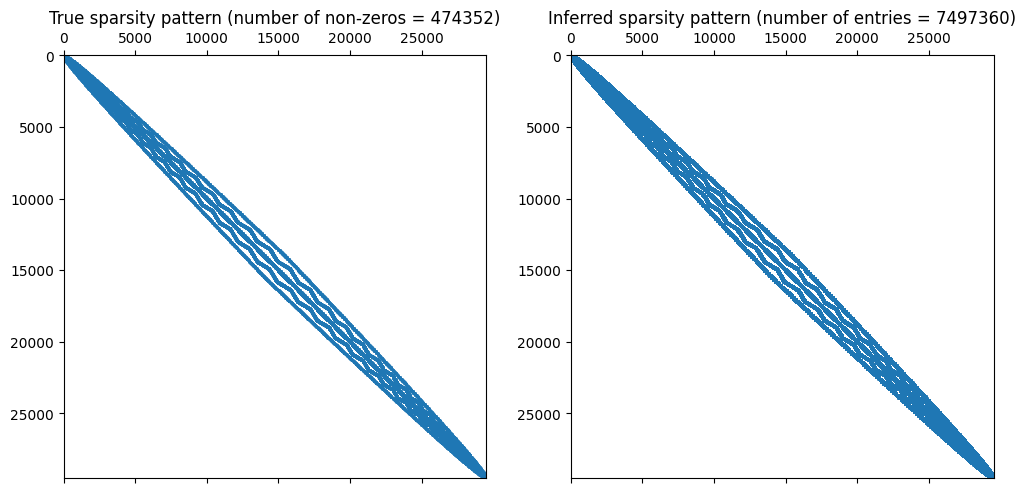

In [31]:
bilinear_form_csr_matrix = csr_matrix(bilinear_form_matrix.getValuesCSR()[::-1])
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].spy(bilinear_form_csr_matrix, markersize=0.5)
axes[0].set_title(f"True sparsity pattern (number of non-zeros = {bilinear_form_csr_matrix.count_nonzero()})")
axes[1].spy(bilinear_form_csr_matrix, markersize=0.5, precision="present")
axes[1].set_title(f"Inferred sparsity pattern (number of entries = {bilinear_form_csr_matrix.nnz})");

In [32]:
# from decimal import Decimal
# "{:.2E}".format(Decimal(np.linalg.cond(bilinear_form_csr_matrix.todense()))) 

Extract solution at final time

In [33]:
final_velocity_function_space_x, dofmap_final_velocity_to_mixed = mixed_function_space.sub(0).sub( number_of_time_slices ).collapse()
final_velocity_x = dolfinx.fem.Function(final_velocity_function_space_x)
final_velocity_x.x.array[:] = velocity_x_primal_solution.x.array[dofmap_final_velocity_to_mixed]

final_velocity_function_space_y, dofmap_final_velocity_to_mixed = mixed_function_space.sub(1).sub( number_of_time_slices ).collapse()
final_velocity_y = dolfinx.fem.Function(final_velocity_function_space_y)
final_velocity_y.x.array[:] = velocity_y_primal_solution.x.array[dofmap_final_velocity_to_mixed]

final_pressure_function_space, dofmap_final_velocity_to_mixed = mixed_function_space.sub(2).sub( number_of_time_slices ).collapse()
final_pressure = dolfinx.fem.Function(final_pressure_function_space)
final_pressure.x.array[:] = pressure_primal_solution.x.array[dofmap_final_velocity_to_mixed]


final_velocity_dual_function_space_x, dofmap_final_dual_velocity_to_mixed_dual = mixed_function_space.sub(3).sub( number_of_time_slices -1 ).collapse()
final_velocity_dual_x = dolfinx.fem.Function(final_velocity_dual_function_space_x)
final_velocity_dual_x.x.array[:] = velocity_x_dual_solution.x.array[dofmap_final_dual_velocity_to_mixed_dual] 

final_velocity_dual_function_space_y, dofmap_final_dual_velocity_to_mixed_dual = mixed_function_space.sub(4).sub( number_of_time_slices -1 ).collapse()
final_velocity_dual_y = dolfinx.fem.Function(final_velocity_dual_function_space_y)
final_velocity_dual_y.x.array[:] = velocity_y_dual_solution.x.array[dofmap_final_dual_velocity_to_mixed_dual] 

final_pressure_dual_function_space, dofmap_final_dual_velocity_to_mixed_dual = mixed_function_space.sub(5).sub( number_of_time_slices -1 ).collapse()
final_pressure_dual = dolfinx.fem.Function(final_pressure_dual_function_space)
final_pressure_dual.x.array[:] =  pressure_dual_solution.x.array[dofmap_final_dual_velocity_to_mixed_dual] 


Compute L2 error of numerical solution compared to exact

In [34]:
# measuring error 
exact_velocity_solution_x =sample_sol_u1(final_time,spatial_coordinate) 
exact_velocity_solution_y =sample_sol_u2(final_time,spatial_coordinate)
l2_error_squared_form = dolfinx.fem.form(
   ( ufl.inner(
        final_velocity_x - exact_velocity_solution_x, 
        final_velocity_x - exact_velocity_solution_x
    ) + ufl.inner(
        final_velocity_y - exact_velocity_solution_y, 
        final_velocity_y - exact_velocity_solution_y
    ) ) * cell_integral
)
l2_error_squared_local = dolfinx.fem.assemble_scalar(l2_error_squared_form)
l2_error_global = np.sqrt(mesh.comm.allreduce(l2_error_squared_local, op=MPI.SUM))
print(f"t = {final_time}, L2 error velocity = {l2_error_global} ")

t = 0.2, L2 error velocity = 0.001023722978908597 


In [35]:
# measuring error 
exact_pressure_solution =sample_sol_p(final_time,spatial_coordinate) 
# exact_velocity_solution_y =sample_sol_u2(final_time,spatial_coordinate)
l2_error_squared_form = dolfinx.fem.form(
   ( ufl.inner(
        final_pressure - exact_pressure_solution, 
        final_pressure - exact_pressure_solution
    )  ) * cell_integral
)
l2_error_squared_local = dolfinx.fem.assemble_scalar(l2_error_squared_form)
l2_error_global = np.sqrt(mesh.comm.allreduce(l2_error_squared_local, op=MPI.SUM))
print(f"t = {final_time}, L2 error pressure = {l2_error_global} ")

t = 0.2, L2 error pressure = 0.46023480894465335 


In [36]:
# measuring error 
#exact_velocity_solution =sample_sol(final_time,spatial_coordinate) 
l2_error_squared_form = dolfinx.fem.form(
   ( ufl.inner(
        final_velocity_dual_x, 
        final_velocity_dual_x
    ) + ufl.inner(
        final_velocity_dual_y, 
        final_velocity_dual_y
    )
   ) * cell_integral
)
l2_error_squared_local = dolfinx.fem.assemble_scalar(l2_error_squared_form)
l2_error_global = np.sqrt(mesh.comm.allreduce(l2_error_squared_local, op=MPI.SUM))
print(f"t = {final_time}, dual L2 = {l2_error_global} ")

t = 0.2, dual L2 = 0.00031522503606853345 


In [37]:
velocity_exact_x = dolfinx.fem.Function(final_velocity_function_space_x)
velocity_exact_x.interpolate(lambda x: sample_sol_np_u1(final_time,x))

In [38]:
error = dolfinx.fem.Function(final_velocity_function_space_x)

In [39]:
error.x.array[:]=np.abs(velocity_exact_x.x.array[:]-final_velocity_x.x.array[:])

In [40]:
# (velocity_exact_x.x.array.size

In [41]:
# (velocity_exact_x.x.array.shape)

In [42]:
velocity_exact_y = dolfinx.fem.Function(final_velocity_function_space_y)
velocity_exact_y.interpolate(lambda x: sample_sol_np_u2(final_time,x))

In [43]:
pressure_exact = dolfinx.fem.Function(final_pressure_function_space)
pressure_exact.interpolate(lambda x: sample_sol_np_p(final_time,x))

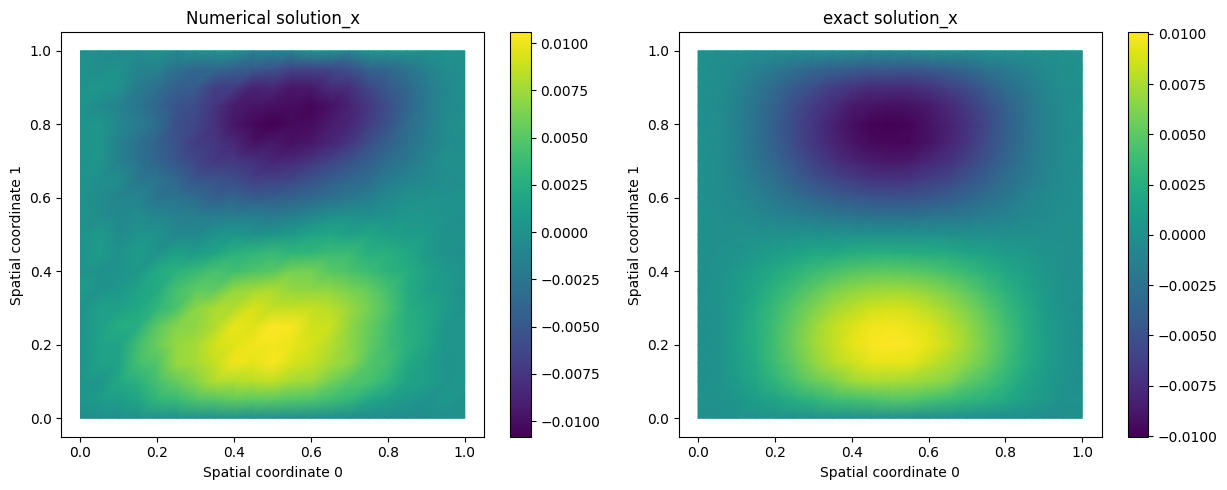

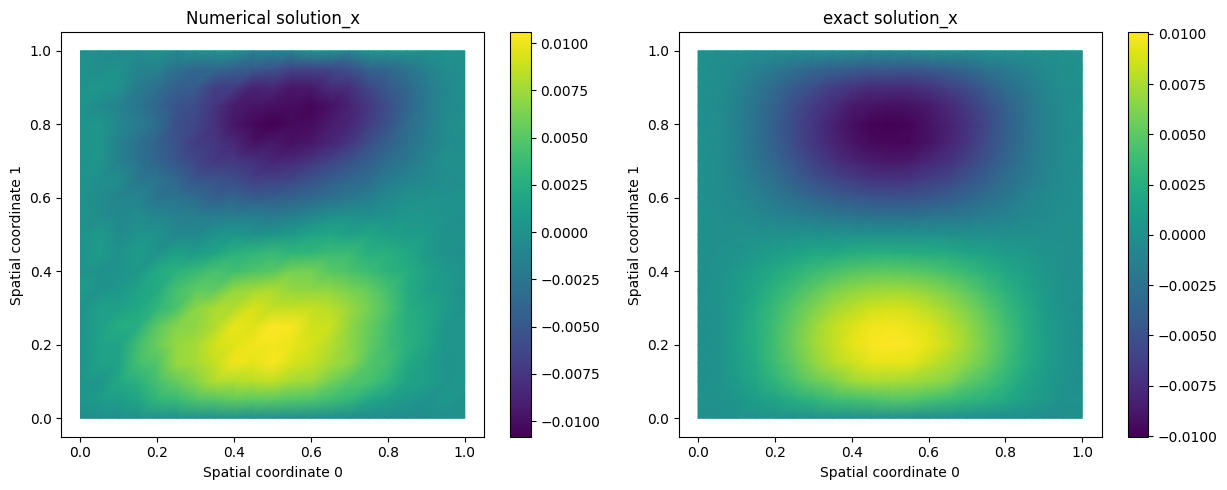

In [44]:
dxh.plot_2d_functions({"Numerical solution_x": final_velocity_x,"exact solution_x": velocity_exact_x } )

In [45]:
# vector= final_velocity_x - exact_velocity_solution_x

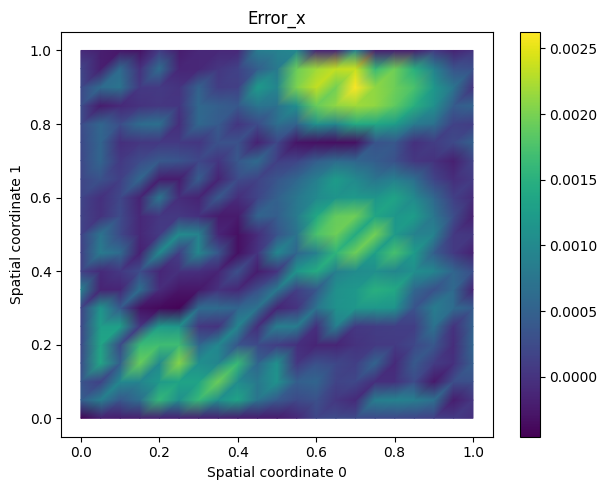

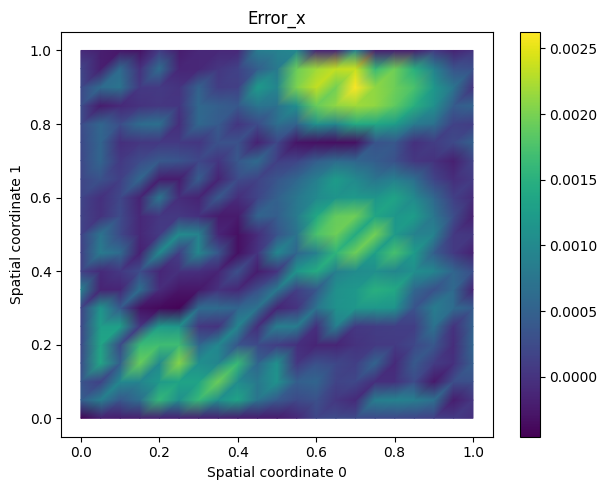

In [46]:
dxh.plot_2d_functions({"Error_x": error,} )

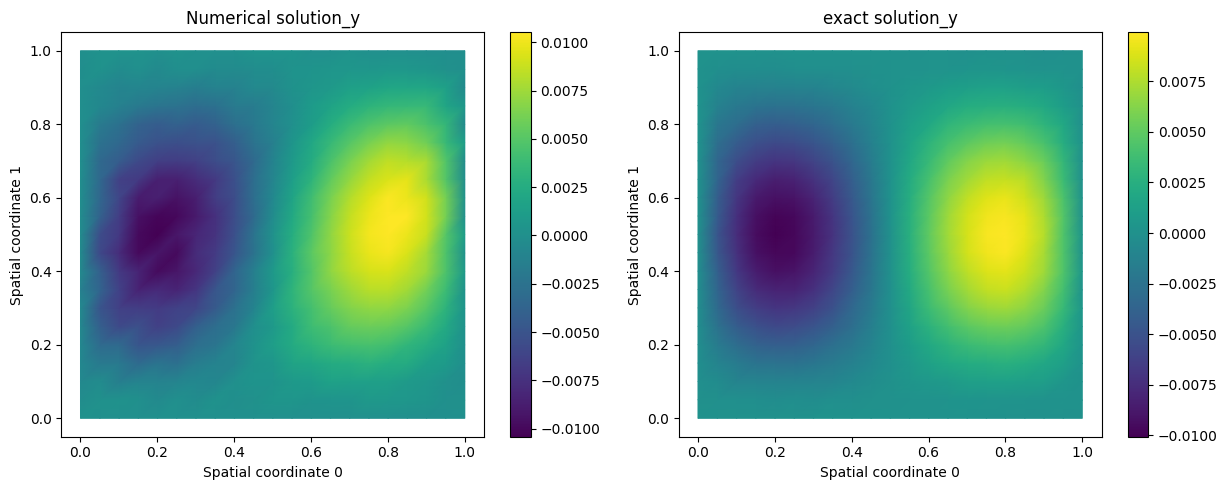

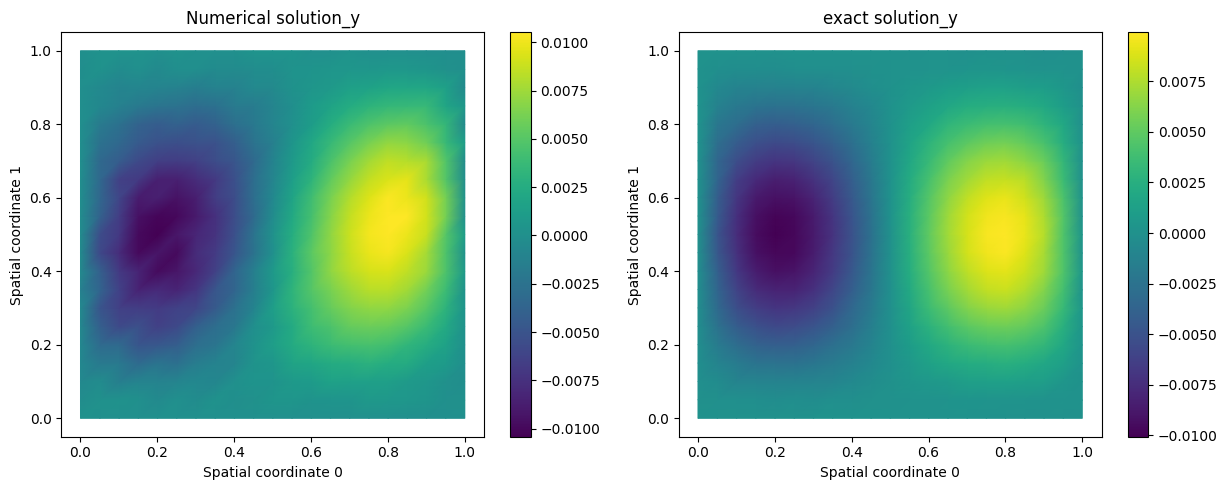

In [47]:
dxh.plot_2d_functions({"Numerical solution_y": final_velocity_y,"exact solution_y": velocity_exact_y } )

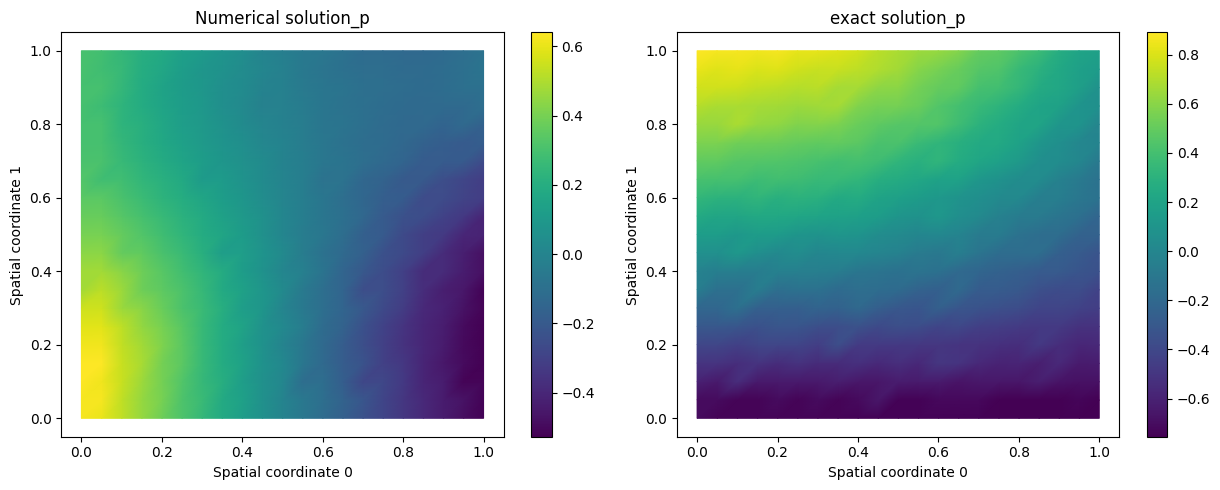

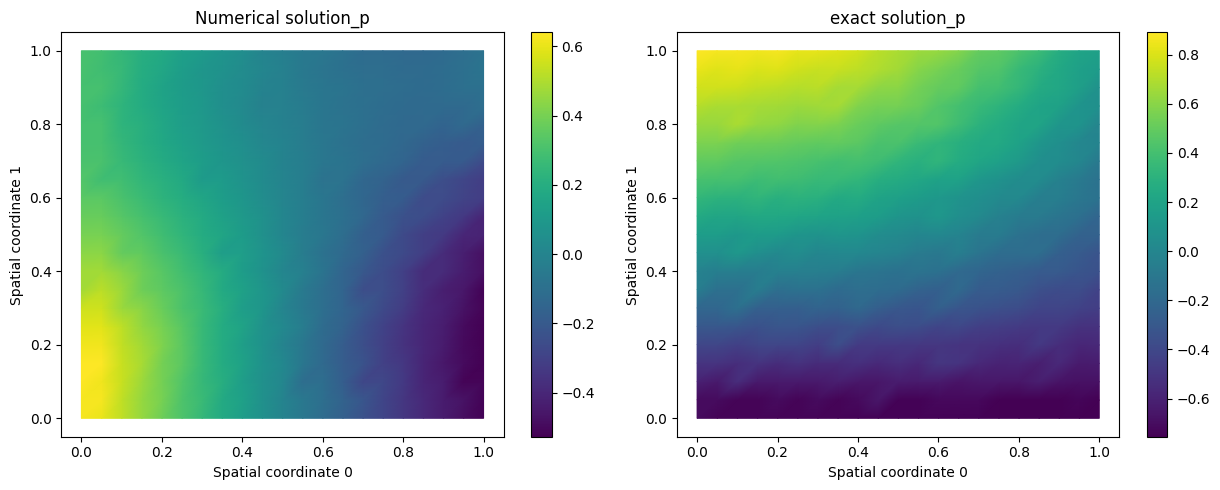

In [48]:
dxh.plot_2d_functions({"Numerical solution_p": final_pressure,"exact solution_p": pressure_exact } )